In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import os
import shutil, sys                                                                                                                                                    

from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary,alpha="auto",eval_every=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/menis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/menis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/menis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#data = pd.read_json("5campaignNew.json")
data = pd.read_json("7postElection.json")
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores
data = data[data["is_retweet"] == False]

data.rename(index=str, columns={"year": "date_year"},inplace=True)
data.rename(index=str, columns={"month": "date_month"},inplace=True)

data.drop(["hour","in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,date_month,date_year,week_year,labels,vaderScore
favorite_count,1.000000,0.891237,-0.164023,0.185635,-0.164811,0.076417,-0.098971
retweet_count,0.891237,1.000000,-0.089613,0.144045,-0.090638,0.090506,-0.166127
date_month,-0.164023,-0.089613,1.000000,-0.302847,0.984279,-0.032168,0.064430
date_year,0.185635,0.144045,-0.302847,1.000000,-0.302369,0.021680,-0.019233
week_year,-0.164811,-0.090638,0.984279,-0.302369,1.000000,-0.034066,0.066510
labels,0.076417,0.090506,-0.032168,0.021680,-0.034066,1.000000,-0.129911
vaderScore,-0.098971,-0.166127,0.064430,-0.019233,0.066510,-0.129911,1.000000


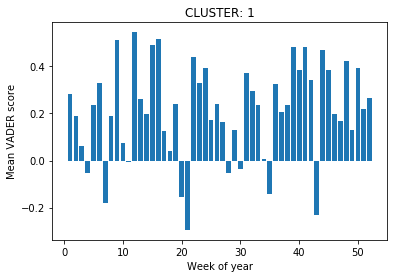

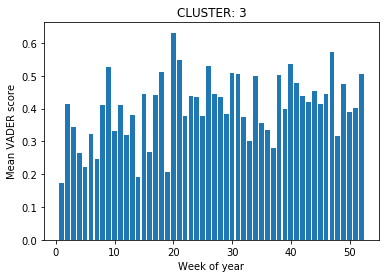

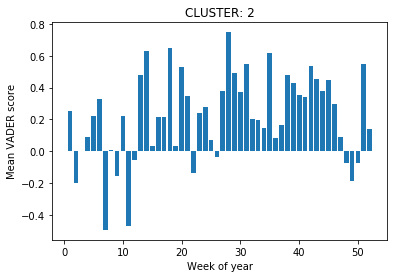

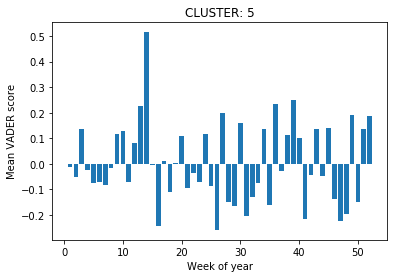

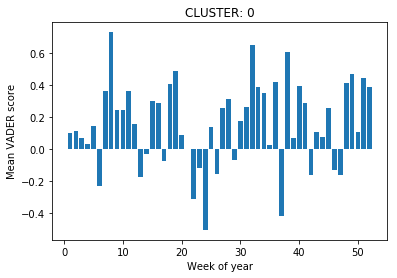

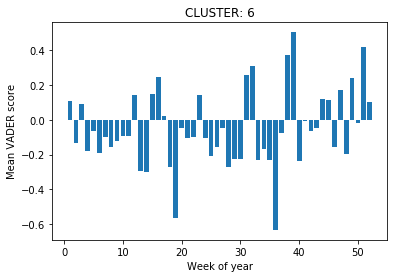

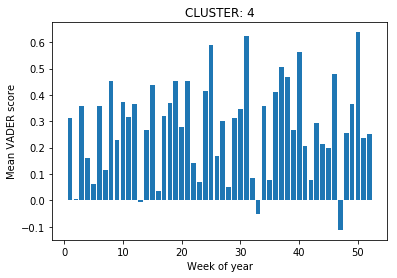

'\n    tata = data[data["labels"] == cluster]\n    tata["vaderScoreBinned"] = pd.cut(tata["vaderScore"], [-1,-0.05,0.05,1], labels=["negative", "neutral", "positive"])\n    tata = tata.groupby(["vaderScoreBinned"])["vaderScore"].count()\n    plt.figure()\n    plt.title("Binned VADER scores, cluster " + str(cluster))\n    plt.ylabel("Number of tweets")\n    plt.xlabel("Bins")\n    plt.bar(tata.index, tata,label=["Negative","Neutral","Positive"] )\n    plt.show()\n'

In [3]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.xlabel("Week of year")
    plt.ylabel("Mean VADER score")
    plt.bar(time.index, time )
    plt.show()
'''
    tata = data[data["labels"] == cluster]
    tata["vaderScoreBinned"] = pd.cut(tata["vaderScore"], [-1,-0.05,0.05,1], labels=["negative", "neutral", "positive"])
    tata = tata.groupby(["vaderScoreBinned"])["vaderScore"].count()
    plt.figure()
    plt.title("Binned VADER scores, cluster " + str(cluster))
    plt.ylabel("Number of tweets")
    plt.xlabel("Bins")
    plt.bar(tata.index, tata,label=["Negative","Neutral","Positive"] )
    plt.show()
'''

In [4]:
taggedDescriptions = []
for idx, row in data.iterrows():
    desc = row["noTags_punct"]
    tokens = word_tokenize(desc)
    tagged = pos_tag(tokens)
    taggedDescriptions.append(tagged)
descriptions = []
for item in taggedDescriptions:
    processed = ""
    for el in item:
        if el[1].startswith("N"): #or el[1].startswith("J"):  #se iniziano con N o J sono nomi o aggettivi, quello che ci serve di più
            processed = processed + " " + el[0]
    descriptions.append(processed)

data["n_j"] = descriptions


In [5]:
majorCluster = 3
d1 = data[data["labels"] == majorCluster ]


#stemmed_words = pd.Series(' '.join(d1['modded1_stemmed']).split()).value_counts()
stemmed_words = pd.Series(' '.join(d1["n_j"]).split()).value_counts()
print(stemmed_words)

stemmed_words = stemmed_words[3:]
stemmed_words = stemmed_words[stemmed_words > 2]
#d1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))
d1["n_j"] = d1["n_j"].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

i                  237
thank              230
today              188
news               113
people             109
country            103
jobs               103
president           99
vote                93
honor               93
time                91
day                 84
america             83
congratulations     80
job                 76
house               74
years               72
border              72
security            66
states              59
media               58
wall                57
election            55
whitehouse          54
tax                 53
year                53
state               50
meeting             49
world               48
crime               46
                  ... 
correction           1
dangers              1
nukes                1
gregg                1
wade                 1
anncoulter           1
hockey               1
specificbut          1
serv                 1
dodgers              1
nbc                  1
norway               1
negotiation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


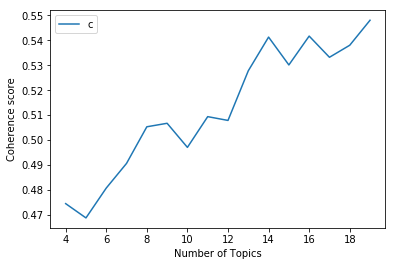

19


In [6]:
from gensim.corpora.dictionary import Dictionary

tokenizer = RegexpTokenizer(r'\w+')

#corpus = d1["m"].tolist()
corpus = d1["n_j"].tolist()
#print(len(corpus))
corp = []
for string in corpus:
    tokens = tokenizer.tokenize(string)
    corp.append(tokens)

common_dictionary = Dictionary(corp)
common_corpus = [common_dictionary.doc2bow(text) for text in corp]
tfidf = TfidfModel(common_corpus)
tfidf_corpus = tfidf[common_corpus]

start,stop,step=4,20,1
nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)

print(nTopics)


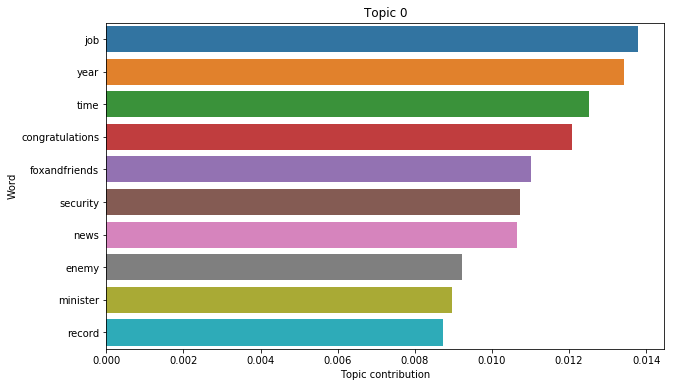

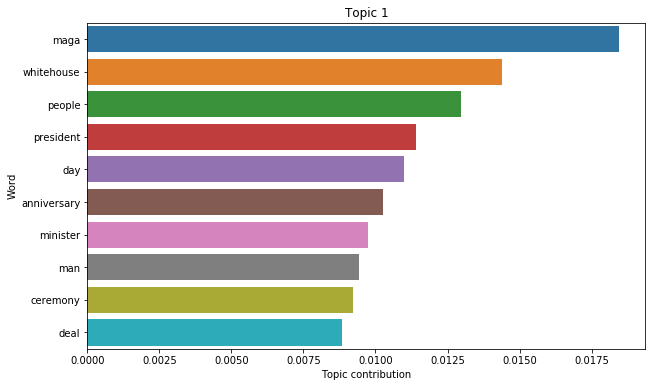

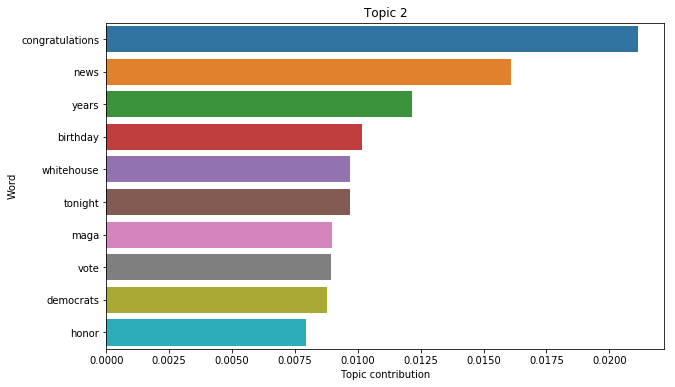

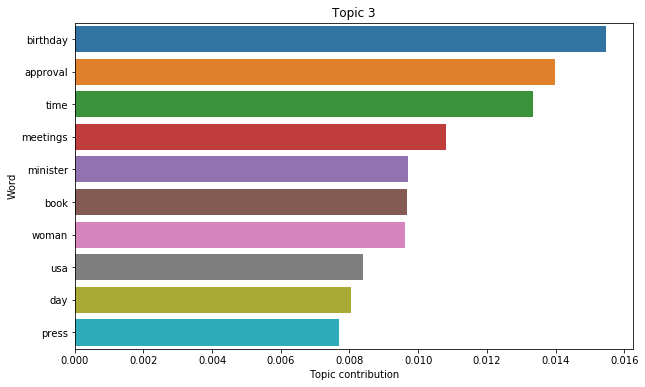

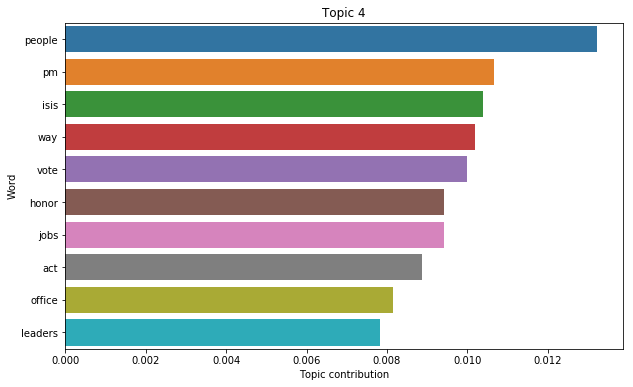

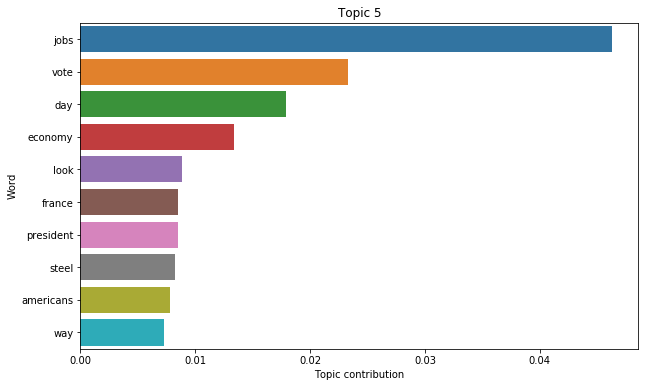

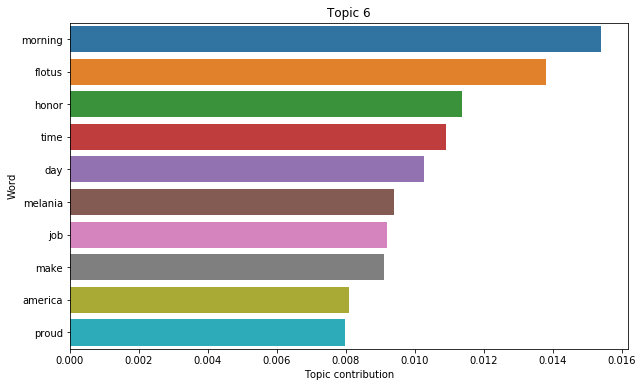

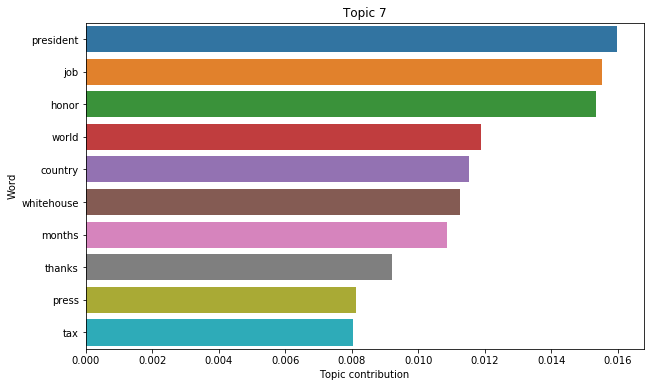

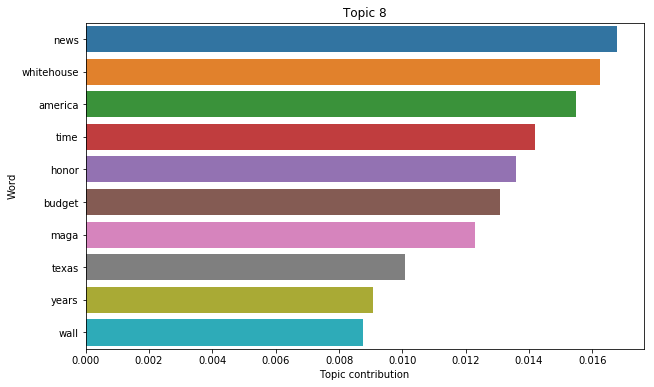

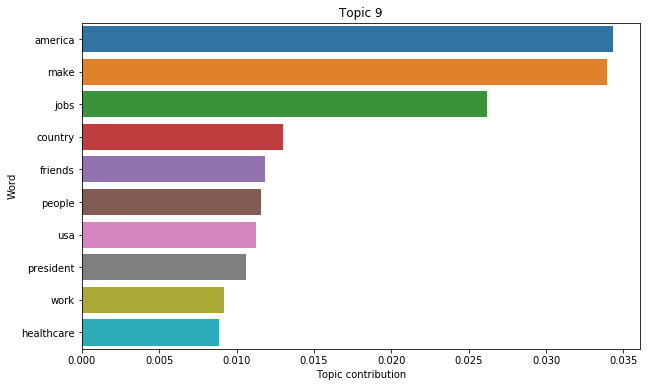

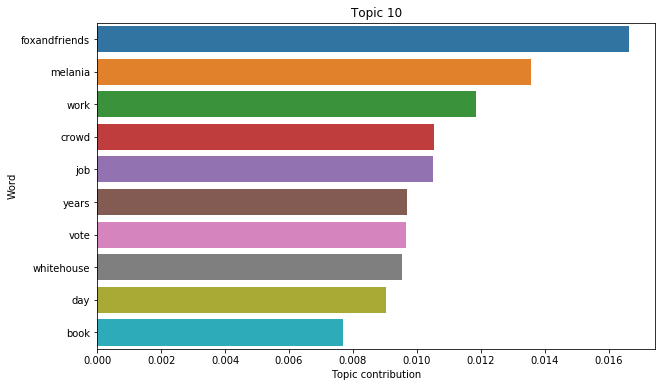

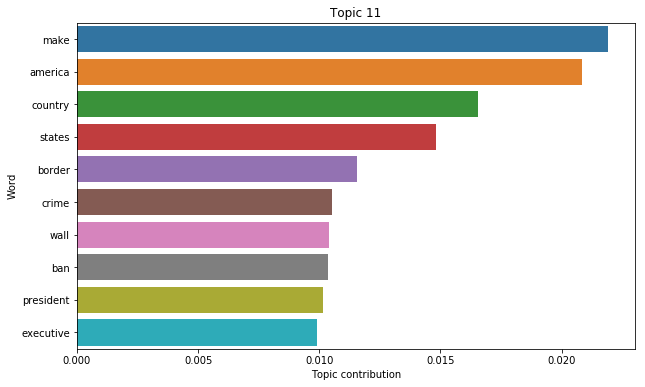

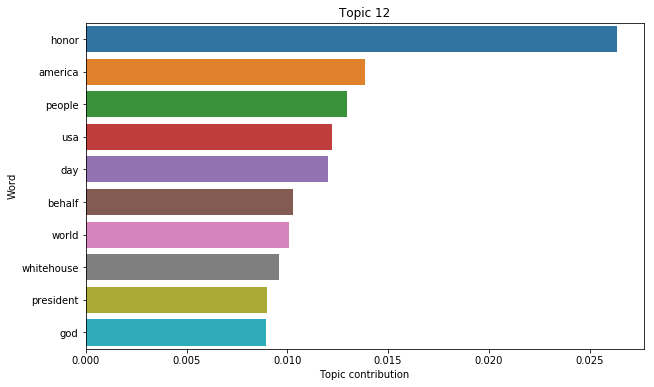

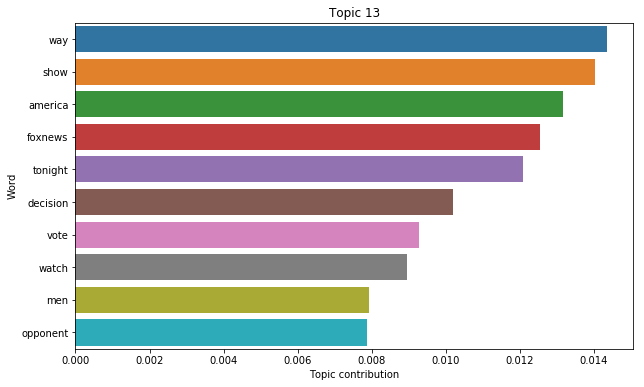

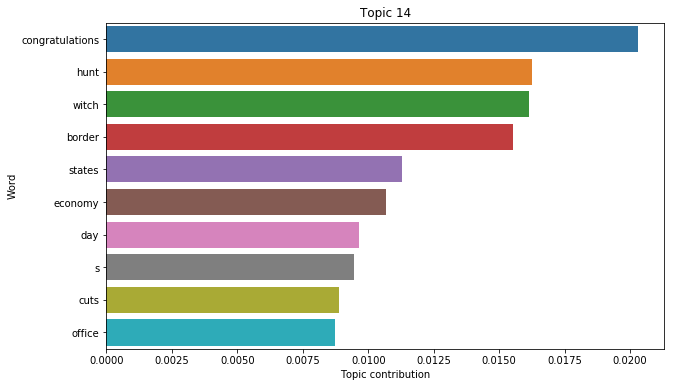

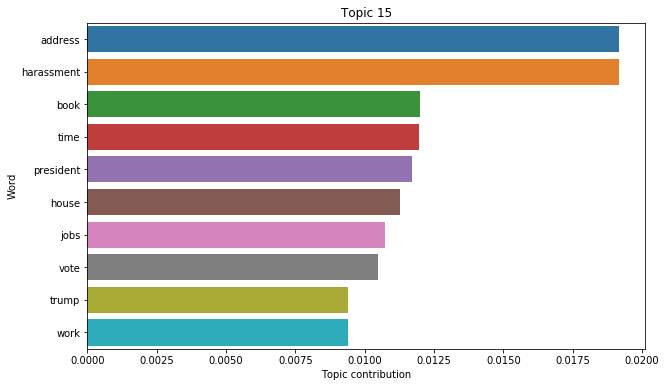

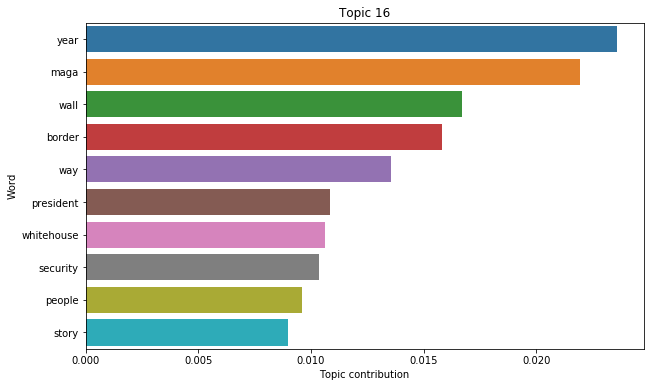

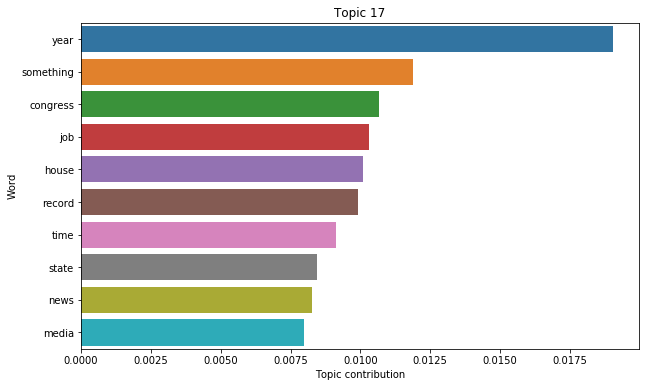

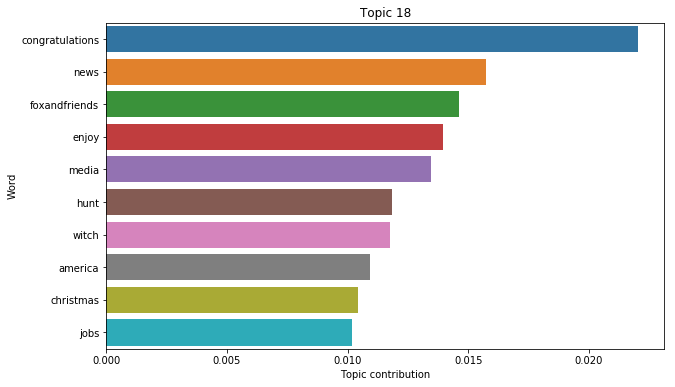

1793 1793
topics_count [221, 110, 106, 105, 104, 101, 101, 100, 96, 87, 86, 85, 79, 74, 73, 70, 70, 64, 61]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
#genera cartella
#path = "campaign/cluster"+str(majorCluster)
path = 'post/cluster'+str(majorCluster)
if os.path.exists(path):
    shutil.rmtree(path)
os.mkdir(path)

#nTopics = 5
lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary,alpha="auto",eval_every=2)

topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False)
#print(g)
topicFigures = []
for topic in topics:
    words = []
    weights = []
    for word in topic[1]:
        if abs(word[1]) > 0.001:
            words.append(word[0])
            #prendi valore assoluto perchè positivo/negativo non ha senso 
            weights.append(abs(word[1]))
    labels = words
    sizes = weights
    fig = plt.figure(figsize=(10, 6))
    plt.title("Topic " + str(topic[0]),figure=fig)
    sns.barplot(x=weights, y=words,figure=fig)
    plt.xlabel("Topic contribution",figure=fig)
    plt.ylabel("Word",figure=fig)
    plt.savefig(path + '/c'+ str(majorCluster) + 't'+ str(topic[0])+ 'weights.png')
    plt.show()     
    topicFigures.append(fig)
topicColumn = []
topicList = {}

for el in tfidf_corpus:
    vector = lda.get_document_topics(el)
    #get topic
    m = max(y for (x,y) in vector)
    ind = [x for x, y in enumerate(vector) if y[1] == m][0]
    #print(ind,m)
    if ind not in topicList:
        topicList[ind] = 1
    else: 
        topicList[ind] += 1
    topicColumn.append(ind)

print(len(topicColumn),len(d1))
d1["topic"] = topicColumn
#print(topicColumn)
print("topics_count",d1["topic"].value_counts().tolist())



(array([138., 192., 176., 146.,  73., 187., 331., 149., 204., 197.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

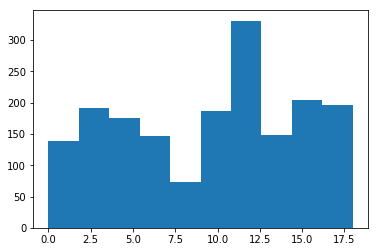

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  
#corpus = d1["m"].tolist()
corpus = d1["n_j"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

d1.reset_index(inplace=True,drop=True)
res = pd.concat([d1,c], axis=1)
#res1 = res.drop(["m","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)
res1 = res.drop(["n_j","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)

dataWithText = res.drop(["week_year","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
#dataWithText = res
res1.columns
plt.hist(res1["topic"])

2 0.7544693260855553
3 0.7002637050953961
4 0.6710266179933866
5 0.5939135277031657
6 0.5381952105408705
7 0.4782076924706345
8 0.4616566574491312
9 0.46964242599930195
10 0.4467568672598587
11 0.428501517917309
12 0.37695445258184057
13 0.36260105586162406
14 0.35163639399601615
15 0.3270205177713959
16 0.315984818158817
17 0.3194105376226896
18 0.31402649048548414
19 0.30837682302251607
20 0.30046261179911415
21 0.2908688906858243


Text(0, 0.5, 'Silhouette score')

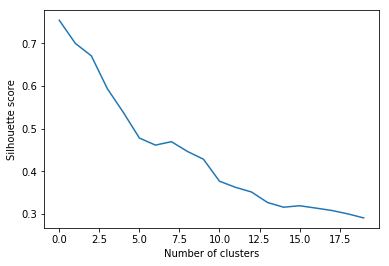

In [9]:
sil = []
for c in range(2,22):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)
plt.plot([x for x in range(0,len(sil))],sil)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

In [10]:
res1 = res.drop(["n_j","week_year","date_month","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1)

dataWithText = res.drop(["week_year","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=11) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)

Index(['date_year', 'vaderScore', 'topic', 'abe', 'abeshinzo', 'account',
       'accountability', 'act', 'action', 'actions',
       ...
       'workers', 'workforce', 'world', 'wow', 'xi', 'yates', 'year', 'years',
       'yesterday', 'york'],
      dtype='object', length=837)
0.428501517917309


In [11]:
res1["labels"] = labels
dataWithText["labels"] = labels

CLUSTER 7
204
2018    86
2017    80
2019    38
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


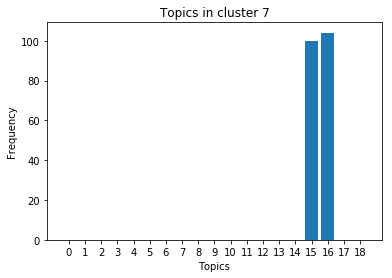

Topic 15:  address harassment book time president house jobs vote trump work
Topic 16:  year maga wall border way president whitehouse security people story


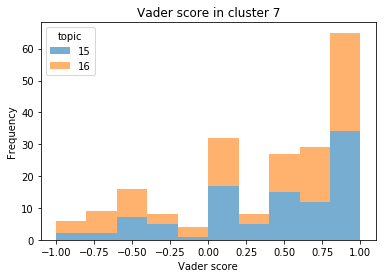

CLUSTER 9
38
2017    19
2018    15
2019     4
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


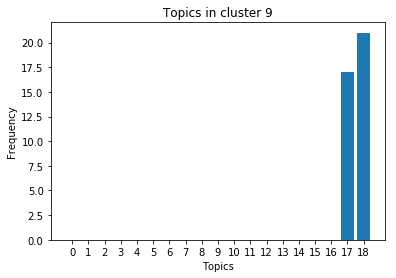

Topic 17:  year something congress job house record time state news media
Topic 18:  congratulations news foxandfriends enjoy media hunt witch america christmas jobs


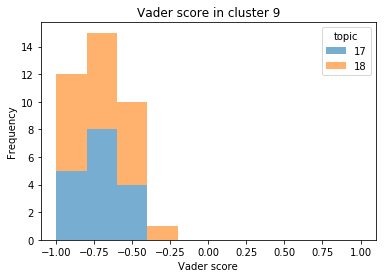

CLUSTER 0
418
2018    214
2017    173
2019     31
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


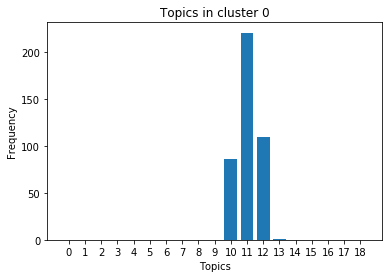

Topic 10:  foxandfriends melania work crowd job years vote whitehouse day book
Topic 11:  make america country states border crime wall ban president executive
Topic 12:  honor america people usa day behalf world whitehouse president god
Topic 13:  way show america foxnews tonight decision vote watch men opponent


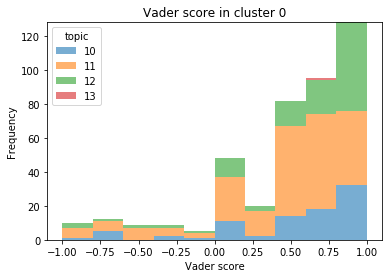

CLUSTER 10
29
2018    17
2017    11
2019     1
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


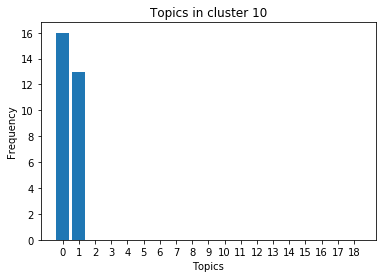

Topic 0:  job year time congratulations foxandfriends security news enemy minister record
Topic 1:  maga whitehouse people president day anniversary minister man ceremony deal


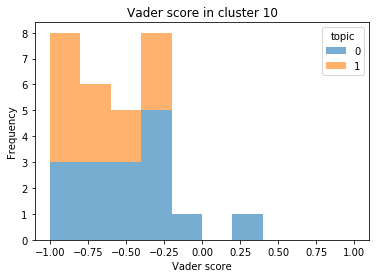

CLUSTER 1
146
2018    77
2017    53
2019    16
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


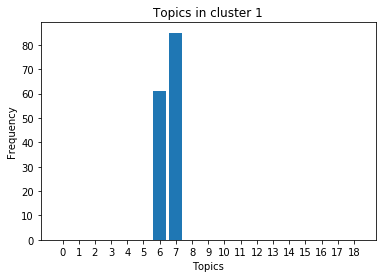

Topic 6:  morning flotus honor time day melania job make america proud
Topic 7:  president job honor world country whitehouse months thanks press tax


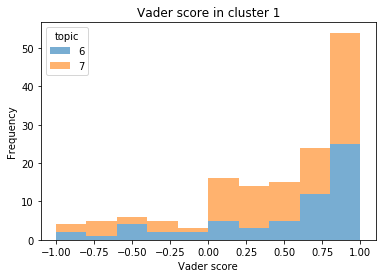

CLUSTER 6
159
2017    72
2018    71
2019    16
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


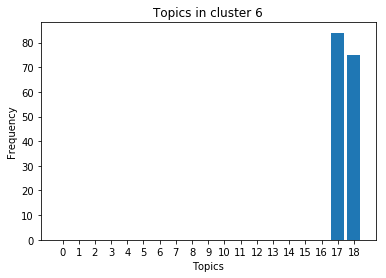

Topic 17:  year something congress job house record time state news media
Topic 18:  congratulations news foxandfriends enjoy media hunt witch america christmas jobs


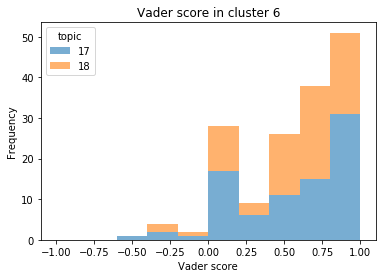

CLUSTER 2
192
2017    92
2018    72
2019    28
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


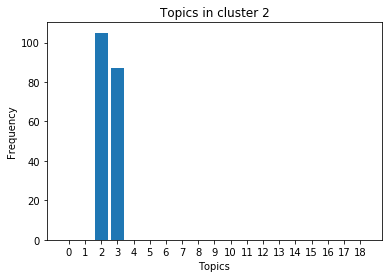

Topic 2:  congratulations news years birthday whitehouse tonight maga vote democrats honor
Topic 3:  birthday approval time meetings minister book woman usa day press


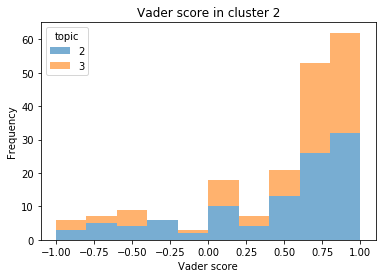

CLUSTER 5
174
2017    82
2018    74
2019    18
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


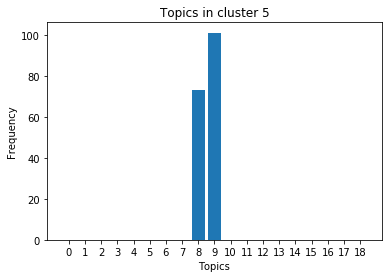

Topic 8:  news whitehouse america time honor budget maga texas years wall
Topic 9:  america make jobs country friends people usa president work healthcare


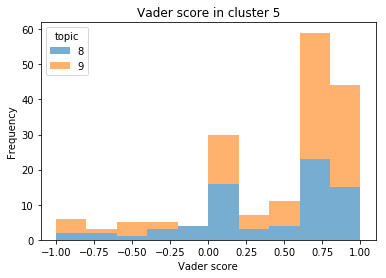

CLUSTER 3
176
2018    87
2017    81
2019     8
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


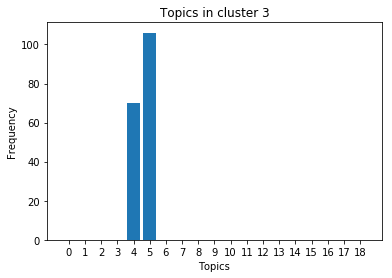

Topic 4:  people pm isis way vote honor jobs act office leaders
Topic 5:  jobs vote day economy look france president steel americans way


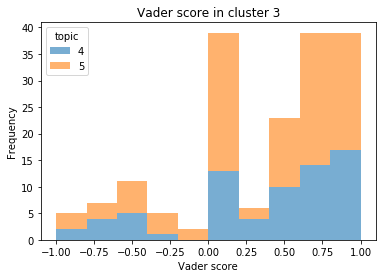

CLUSTER 4
148
2018    76
2017    60
2019    12
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


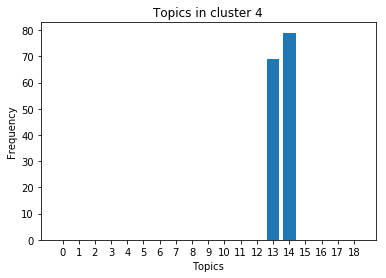

Topic 13:  way show america foxnews tonight decision vote watch men opponent
Topic 14:  congratulations hunt witch border states economy day s cuts office


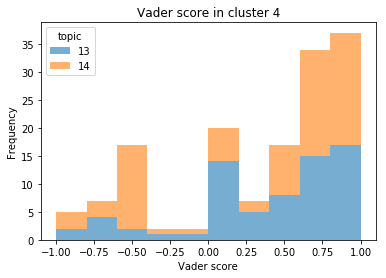

CLUSTER 8
109
2017    53
2018    48
2019     8
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


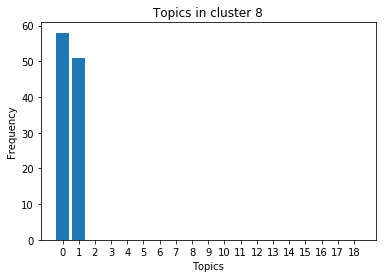

Topic 0:  job year time congratulations foxandfriends security news enemy minister record
Topic 1:  maga whitehouse people president day anniversary minister man ceremony deal


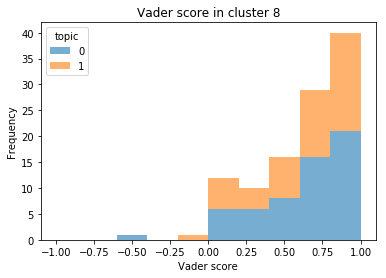

In [15]:

for cluster in res1["labels"].unique():
    path = 'post/cluster'+str(majorCluster)+'/subcluster'+ str(cluster)
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

    g1 = res1[res1["labels"] == cluster]

   # temp = dataWithText[dataWithText["labels"] == cluster]


    #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
    #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")
    print("CLUSTER " + str(cluster))
    print(len(g1))
    print(g1["date_year"].value_counts())
    print(g1["date_year"].unique().tolist())
    print("anni nel cluster ", len(g1["date_year"].unique().tolist()))
    #print(temp["week_year"].unique().tolist())
   # print("numero di settimane in cluster", len(temp["week_year"].unique().tolist()))

    #plt.hist(g1["topic"],bins=[0,1,2,3,4,5,6,7,8,9,10])
    #plt.title("topicdistrib in cluster " + str(cluster))
    #plt.show()
    
    #plot bar chart with topics
    counts = g1["topic"].value_counts()
    arr = [0 for x in range(0,nTopics)]
    topicStrings = []
    for i in range(0,len(arr)):
        if i in counts:
            arr[i] = counts[i]
            topicStr = ""
            for el in topics[i][1]:
                topicStr += " " + el[0] 
            topicStrings.append([i,topicStr])
    ind = [i for i in range(0,nTopics)]    
    plt.bar(ind,arr)
    plt.title("Topics in cluster " + str(cluster))
    plt.xticks(np.arange(0, nTopics, step=1))
    plt.xlabel("Topics")
    plt.ylabel("Frequency")
    plt.savefig(path + '/sub'+ str(cluster) + 'topicDistribution'+ '.png')
    plt.show()
    
    for el in topicStrings:
        print("Topic " + str(el[0]) + ": " + el[1])

    g1.pivot(columns='topic').vaderScore.plot(kind = 'hist',alpha=0.6,stacked=True,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
    plt.title("Vader score in cluster " + str(cluster) )
    plt.xlabel("Vader score")
    plt.savefig(path + '/sub'+ str(cluster) + 'VaderScore'+ '.png')
    plt.show()


    #save info in text file
    file = open(path + "/generalInfo.txt","w")
    
    file.write("cluster "+str(cluster) +" lunghezza " + str(len(g1)) + "\n") 
    file.write("Mean vader: " + str(g1["vaderScore"].mean()) + "\n")
    for el in topicStrings:
        file.write("Topic " + str(el[0]) + ": " + el[1] + " \n")
    file.write("NUMBER OF TOPICS FOR CLUSTER "+ str(cluster)+ " : "+ str(nTopics) + "\n") 
    file.write(g1["date_year"].value_counts().to_string()+ "\n")
    file.close()

